网络一共由3个卷积层和2个全连接层构成。是一个比较简单的网络

In [2]:
import torch
from torchvision import models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
import torch.nn as nn

In [4]:
root_dir = "./train"
import os 
from PIL import Image
imgs_name = os.listdir(root_dir)

imgs_path = []
labels_data = []

for name in imgs_name:
    if name[:3] == "dog":
        label = 0
    if name[:3] == "cat":
        label = 1
    img_path = os.path.join(root_dir,name)
    imgs_path.append(img_path)
    labels_data.append(label)


In [5]:
from sklearn.model_selection import train_test_split
train_imgs_path,valid_imgs_path,train_labels,valid_labels = train_test_split(imgs_path,labels_data,test_size=0.2,shuffle=True)

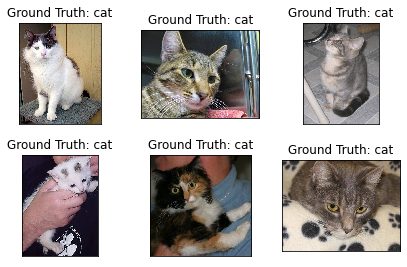

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure()

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  img = Image.open(train_imgs_path[i])
  plt.imshow(img, interpolation='none')
  plt.title("Ground Truth: {}".format("cat" if train_labels[i]==1 else "dog"))
  plt.xticks([])
  plt.yticks([])
plt.show()

In [7]:
import torch
from torch.utils.data import Dataset,DataLoader
import torchvision
from torchvision import datasets,transforms
import os 
from PIL import Image

my_transforms = transforms.Compose([
    transforms.Resize(75),
    transforms.RandomResizedCrop(64), #随机裁剪一个area然后再resize
    transforms.RandomHorizontalFlip(), #随机水平翻转
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


class CatDogDataset(Dataset):
    def __init__(self,imgs_path,labels,my_transforms):
        self.my_transforms = my_transforms
        self.imgs_path = imgs_path
        self.labels = labels
        self.len = len(self.imgs_path)

    def __getitem__(self,index):
        img = Image.open(self.imgs_path[index])
        return my_transforms(img),self.labels[index]

    def __len__(self):
        return self.len
    
train_dataset = CatDogDataset(train_imgs_path,train_labels,my_transforms)
valid_dataset = CatDogDataset(valid_imgs_path,valid_labels,valid_transforms)

train_loader = DataLoader(train_dataset,1024,shuffle=True,num_workers=16)
valid_loader = DataLoader(valid_dataset,512,num_workers=16)

In [8]:
import torch.nn.functional as F
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.25)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32,64,kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.25)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64,128,kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.25)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128*6*6,256),
            nn.Dropout(0.2),
            nn.Linear(256,2),
        )
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return F.log_softmax(x,dim=1)
        
my_net = MyNet().to(device)

In [10]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
log_writer = SummaryWriter()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_net.parameters(),lr=0.01,momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,50)


In [11]:
checkpoint = torch.load("临时保存的模型.h5")
epoch = checkpoint['epoch']
my_net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler'])
print(epoch)

782


In [12]:
def train_loss_acc():
    correct = 0
    total = 0
    losses = 0
    for i,data in enumerate(train_loader):
        train_imgs,train_labels = data
        train_imgs = train_imgs.to(device)
        train_labels = train_labels.to(device)
        outputs = my_net(train_imgs)
        _,predict_label = torch.max(outputs,1)
        total += train_labels.size(0)
        correct += (predict_label == train_labels).sum().item()
        loss = criterion(outputs,train_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses += loss.item()

    return losses/(i+1),correct/total


def valid_loss_acc():
    losses = 0
    correct = 0
    total = 0
    for i,data in enumerate(valid_loader):
        valid_imgs,valid_labels = data
        valid_imgs = valid_imgs.to(device)
        valid_labels = valid_labels.to(device)
        outputs = my_net(valid_imgs)
        loss = criterion(outputs,valid_labels)
        losses += loss.item()
        _,predict_label = torch.max(outputs,1)
        total += valid_labels.size(0)
        correct += (predict_label == valid_labels).sum().item()
    return losses/(i+1),correct/total

for epoch in range(epoch,1000):
    
    my_net.train()
    train_loss,train_acc = train_loss_acc()

    log_writer.add_scalar("Loss/train",float(train_loss),epoch)
    log_writer.add_scalar("Acc/train",float(train_acc),epoch)

    my_net.eval()
    valid_loss,valid_acc = valid_loss_acc()
    log_writer.add_scalar("Loss/valid",float(valid_loss),epoch)
    log_writer.add_scalar("Acc/valid",float(valid_acc),epoch)
    
    scheduler.step()
    if epoch % 20 == 1:
        print("epoch:{} 训练集准确率：{}，loss：{:.3}, 验证集：{}，loss：{:.3}".format(epoch,train_acc,train_loss,valid_acc,valid_loss))
        

epoch:801 训练集准确率：0.86535，loss：0.298, 验证集：0.8542，loss：0.342
epoch:821 训练集准确率：0.86985，loss：0.288, 验证集：0.8718，loss：0.3
epoch:841 训练集准确率：0.87465，loss：0.273, 验证集：0.8886，loss：0.26
epoch:861 训练集准确率：0.87265，loss：0.277, 验证集：0.881，loss：0.273
epoch:881 训练集准确率：0.86815，loss：0.285, 验证集：0.8706，loss：0.301
epoch:901 训练集准确率：0.8654，loss：0.287, 验证集：0.8614，loss：0.338
epoch:921 训练集准确率：0.87385，loss：0.279, 验证集：0.8834，loss：0.266
epoch:941 训练集准确率：0.8763，loss：0.271, 验证集：0.8876，loss：0.266
epoch:961 训练集准确率：0.8791，loss：0.268, 验证集：0.889，loss：0.255
epoch:981 训练集准确率：0.8758，loss：0.275, 验证集：0.8684，loss：0.314


In [13]:
torch.save(my_net,"猫狗分类自定义网络.h5")

In [15]:
my_net.eval()
valid_loss,valid_acc = valid_loss_acc()
print("最终准确率为：{}".format(valid_acc))

最终准确率为：0.8726
